In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [242]:
crazy_data = pd.read_csv("crazy_data.csv")
crazy_data.head()

,order_id,customer_id,product,quantity,price,currency,date,shipping_weight,state
0,1001,2001,Laptopp,1,999,USD,2024-11-01,2.5,CA
1,1002,2002,Phone Case,2,15,usd,2024/11/01,0.1,Califronia
2,1003,2003,USB Cable,-3,8,USD,2024-11-02,0.05,CA
3,1004,2003,USB Cable,3,8,USD,2024-11-02,0.05,CA
4,1005,2004,Wireless Mouse,1,25,EUR,2024-11-02,0.2,WA


In [243]:
df = crazy_data.copy()

In [244]:
# Remove any weird formatting in price column
price_fix = df['price'].astype(str).str.strip(to_strip='$').str.replace(r'[^0-9.\-]', '', regex=True).replace('', pd.NA).astype(float)
df['price'] = price_fix

# fix currency discrepencies
df['currency'] = df['currency'].str.upper().str.strip()

In [245]:
# Flag negative or zero quantities
df['flag_neg_quantity'] = df['quantity'] <= 0

# Fix formatting in quantity column
df.loc[df['quantity'] <= 0, 'quantity'] = None

In [246]:
# convert order_date to datetime structure
df['date'] = pd.to_datetime(df['date'], errors='coerce') # 'coerce' sets invalid values to NaT

In [247]:
# Clean up the categorical columns
# Normalize products column
product_map = {
    'Electronics': 'Electronics',
    'Eletronics': 'Electronics',
    'electronix': 'Electronics',
    'PhoneCase': 'Accessories',
    'Phone Cases': 'Accessories',
}

df['product'] = (df['product'].astype(str).str.strip().map(lambda x: product_map.get(x, x))) #keep unknowns

In [248]:
# Fix state codes
df['state'] = df['state'].str.upper().str.strip()

# Fix common typos
df['state'] = df['state'].replace({
    'CALIFRONIA': 'CA',
    'CALIFORIA': 'CA',
    'MINN': 'MN',
})

In [249]:
# Detect duplicates in order and customer IDs
dupes = df[df.duplicated(subset=['customer_id', 'order_id'], keep=False)]
dupes

,order_id,customer_id,product,quantity,price,currency,date,shipping_weight,state,flag_neg_quantity


In [250]:
# Flag suspicious records
# Future dates
df['flag_future_date'] = df['date'] > pd.Timestamp.today()

# Odd quantities or prices
df['flag_outlier_qty'] = df['quantity'] > 500
df['flag_outlier_price'] = df['price'] > 2000

In [251]:
# Clean up weight discrepencies
df['shipping_weight'] = (df['shipping_weight'].str.replace(r'\D+', '', regex=True).replace('', np.nan).astype(float)) 

In [252]:
# Fix up value types
df['order_id'] = df['order_id'].astype(str)
df['customer_id'] = df['customer_id'].astype(str)

In [253]:
clean_data = df
clean_data.head()

,order_id,customer_id,product,quantity,price,currency,date,shipping_weight,state,flag_neg_quantity,flag_future_date,flag_outlier_qty,flag_outlier_price
0,1001,2001,Laptopp,1.0,999.0,USD,2024-11-01,25.0,CA,False,False,False,False
1,1002,2002,Phone Case,2.0,15.0,USD,NaT,1.0,CA,False,False,False,False
2,1003,2003,USB Cable,NaN,8.0,USD,2024-11-02,5.0,CA,True,False,False,False
3,1004,2003,USB Cable,3.0,8.0,USD,2024-11-02,5.0,CA,False,False,False,False
4,1005,2004,Wireless Mouse,1.0,25.0,EUR,2024-11-02,2.0,WA,False,False,False,False


In [254]:
outlier_qty = clean_data.loc[clean_data['flag_outlier_qty'] == 1]
neg_quantity = clean_data.loc[clean_data['flag_neg_quantity'] == 1]
future_dates = clean_data.loc[clean_data['flag_future_date'] == 1]
outlier_price = clean_data.loc[clean_data['flag_outlier_price'] == 1]

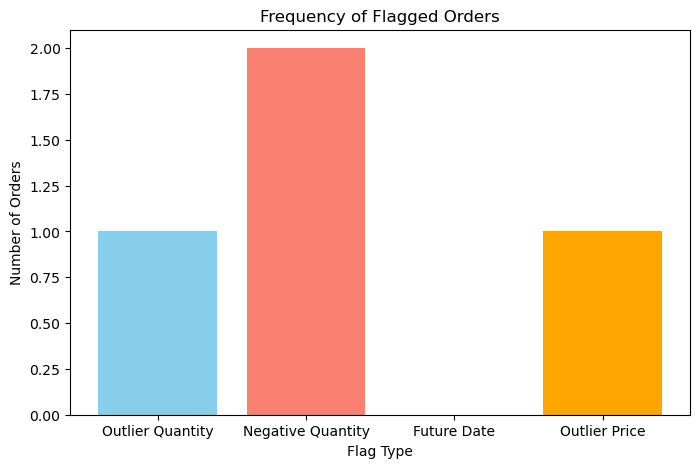

In [ ]:
# Count flagged items
flag_counts = {
    'Outlier Quantity': len(outlier_qty),
    'Negative Quantity': len(neg_quantity),
    'Future Date': len(future_dates),
    'Outlier Price': len(outlier_price)
}

# Plot
plt.figure(figsize=(8,5))
plt.bar(flag_counts.keys(), flag_counts.values(), color=['skyblue','salmon','lightgreen','orange'])
plt.title('Frequency of Flagged Orders')
plt.ylabel('Number of Orders')
plt.xlabel('Flag Type')
plt.show()